# Notebook Setup

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import numpy as np
import matplotlib.pyplot as plt

import os
import sys

sys.path.insert(1, '../')

from moments_toolkit import moments_toolkit

from moments_toolkit import jackknife, plateau_search, effective_mass_formula
from moments_toolkit import bootstrap

import gvar as gv

from scipy.optimize import curve_fit

In [2]:
p3fold = os.environ['mount_point_path'] + "48c48/binned_1012_hmz370_BMW_extended/3PointCorrelation/"
p2fold = os.environ['mount_point_path'] + "48c48/binned_1012_hmz370_BMW_extended/2PointCorrelation/"


opAnalyzer = moments_toolkit(p3fold, p2fold,
                            skip3p=False, skipop=False,
                            verbose=True,
                            fast_data_folder = "../fast_data_extended_p0_q0",
                            operator_folder= "../operator_database",
                            momentum='PX0_PY0_PZ0',
                            insertion_momentum = 'qx0_qy0_qz0',
                            tag_2p='hspectrum',
                            max_n=2 #max_n=3
                            )


Initializing the moments_toolkit class instance...


Initializing the building block class instance...


Reading the the keys of the dataset ...


Reading the 2 point and 3 point correlators from the fast access dataset ...


Reading the list of all the available operators from the database...


Class Initialization Complete!



# Validation of Fit Routine

## Plateau Determination

In [3]:
#we first take the 2point corr
p2corr = opAnalyzer.get_p2corr() # shape = (nconf, latticeT)

#first we determine the gauge avg of the 2p corr using the jackknife and we store it for a later use
p2corr_jack, p2corr_jack_std, p2corr_jack_cov = jackknife(p2corr, lambda x: np.mean( x, axis=0), res_axis_list=0, time_axis=-1)
#p2corr_jack, p2corr_jack_std, p2corr_jack_cov = bootstrap(p2corr, lambda x: np.mean( x, axis=0), res_axis_list=0, time_axis=-1, Nres=1000)

#then we use the jackknife to compute a value of the effective mass (mean, std and cov)
meff_raw, meff_std_raw, meff_covmat_raw = jackknife(p2corr, effective_mass_formula, res_axis_list=0, time_axis=-1) #raw becaus there still are values of the mass that are 0
#meff_raw, meff_std_raw, meff_covmat_raw = bootstrap(p2corr, effective_mass_formula, res_axis_list=0, time_axis=-1,Nres=1000)

#these values of the effective mass are "raw" because they still contain <=0 values (and also padding from the effective mass function)

#meff_raw/meff_std_raw
#np.where(meff_raw/meff_std_raw<=-0.2)

#we look at the point where the mass starts to be negative
#cut=np.where(meff_std_raw<=0)[0][0]
#cut=np.where(meff_raw<=0)[0][0]
cut=np.where(meff_raw/meff_std_raw<=-0.2)[0][0]

#and we cut the meff arrays there
meff = meff_raw[:cut]
meff_std = meff_std_raw[:cut]
meff_covmat = meff_covmat_raw[:cut,:cut]

#we can now identify the boundaries of the plateau region
start_plateau, end_plateau = plateau_search(meff, meff_covmat, only_sig=True, chi2_treshold=1.0) #we search the plateau not using the whole correlation matrix

#we define the gaussian variables corresponding to the valeus of the effective mass in the plateau region
gv_meff = gv.gvar(meff[start_plateau:end_plateau], meff_std[start_plateau:end_plateau])

#we then obtain the plateau value by taking the weighted average of these values (weighted by the inverse of the variance)
gv_meff_plateau = np.average(gv_meff,weights=[1/e.sdev**2 for e in gv_meff])

gv_meff_plateau
opAnalyzer.lattice_to_MeV( gv_meff_plateau )

/tmp/ipykernel_2437289/1186198114.py:20: RuntimeWarning: invalid value encountered in divide
  cut=np.where(meff_raw/meff_std_raw<=-0.2)[0][0]


0.5683(25)

964.3(5.4)

In [4]:
np.exp( np.log(gv.gvar(1,1)) )

1.0(1.0)

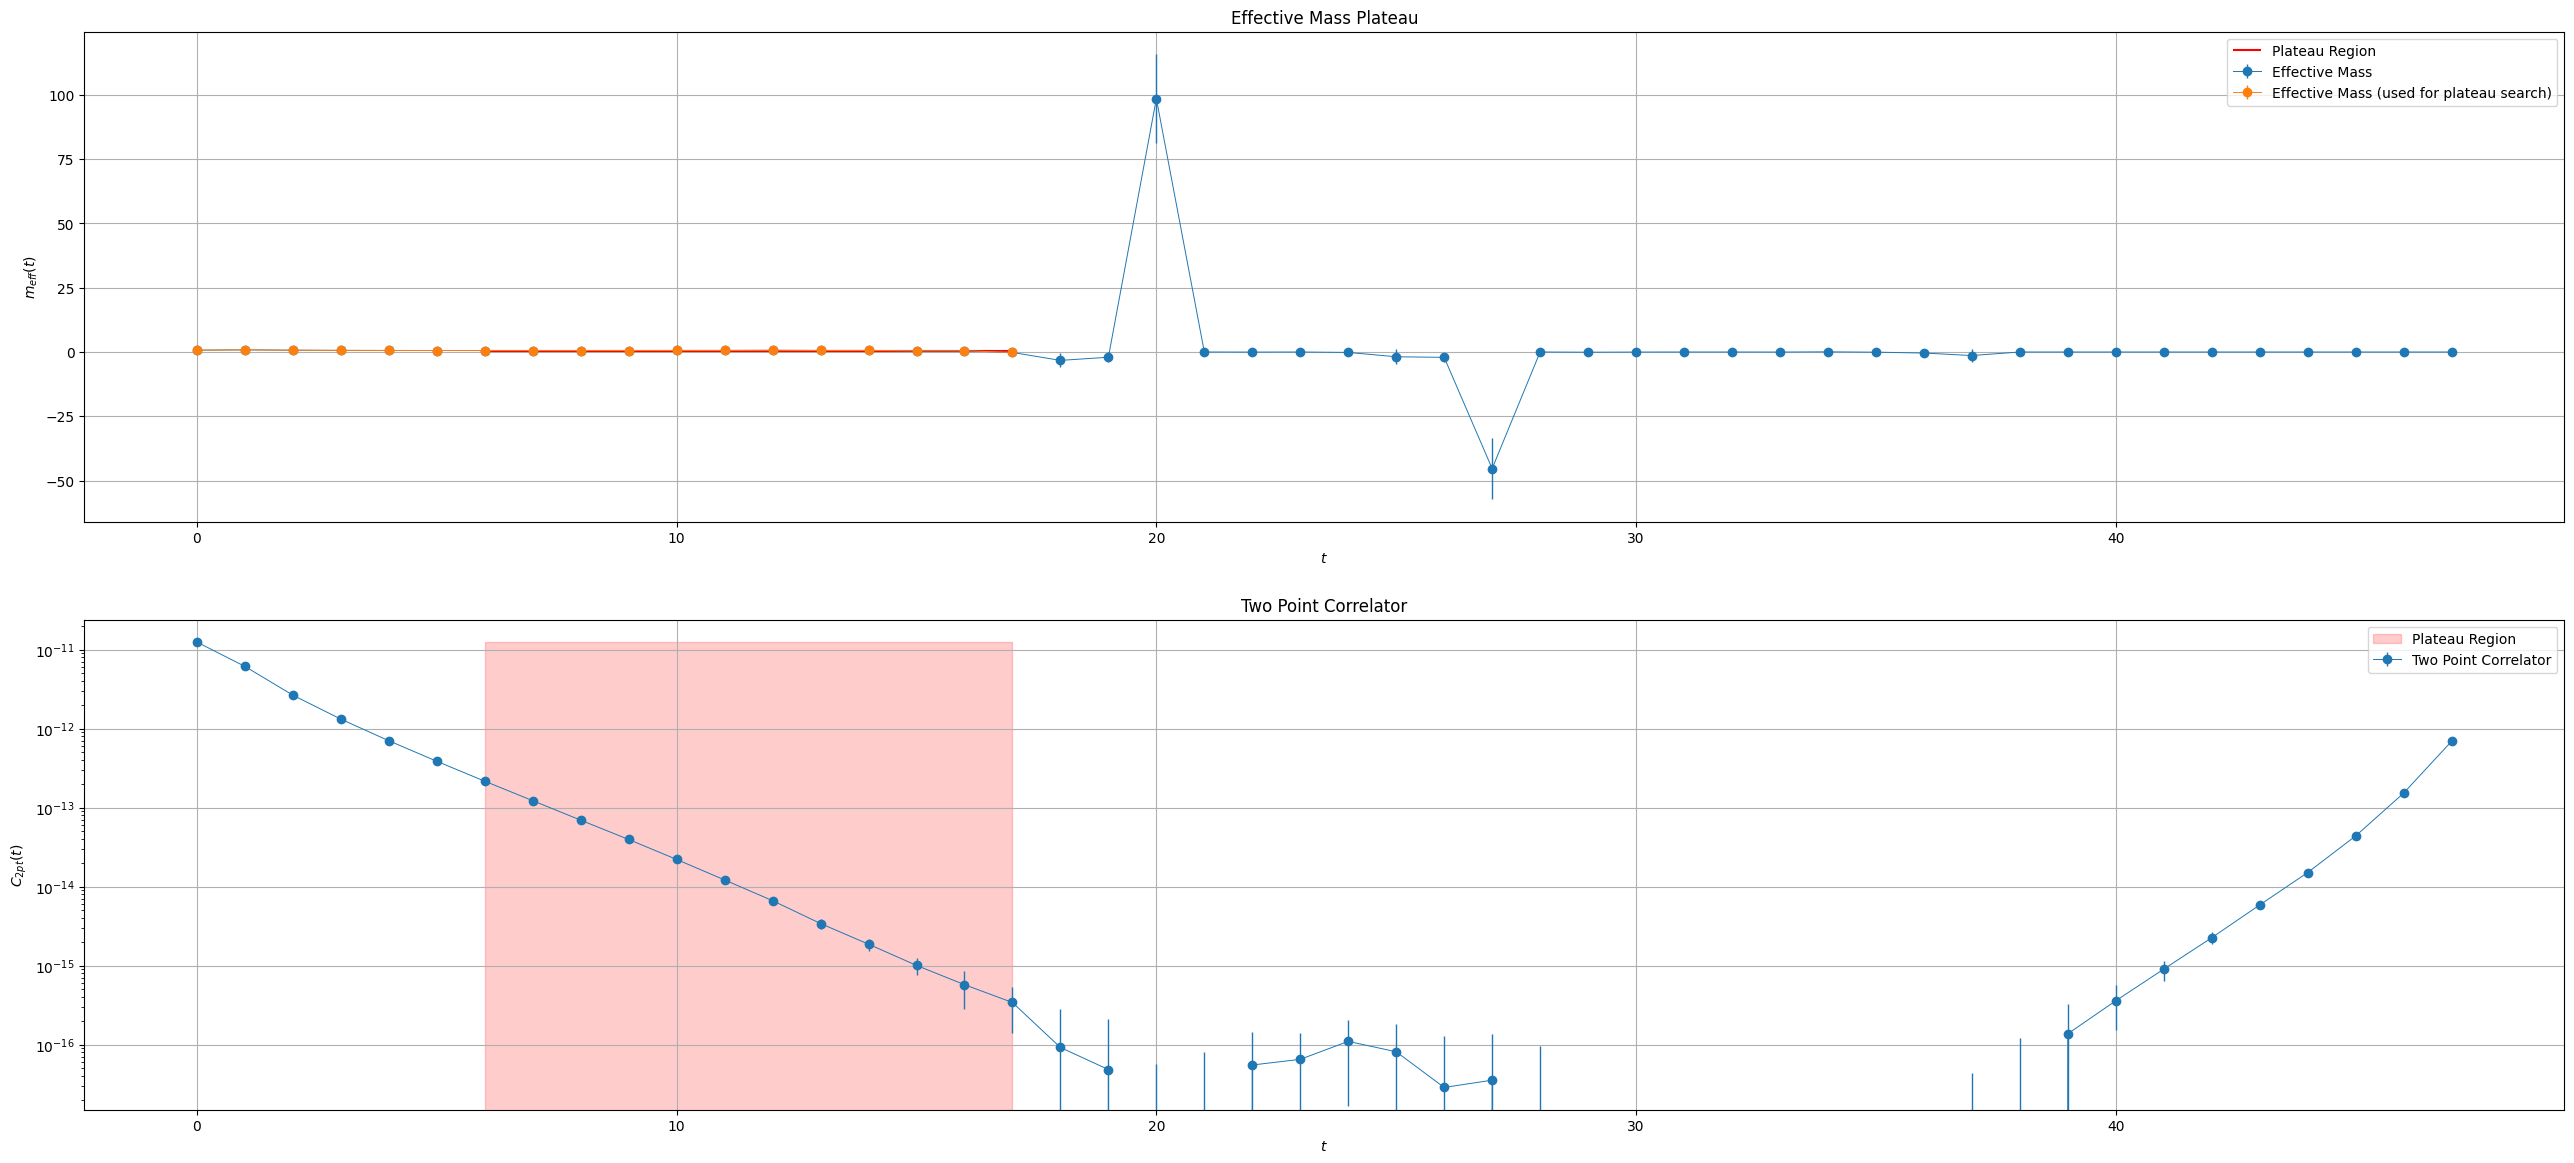

In [5]:
#we instantiate the figure
fig, axlist = plt.subplots(nrows=2,ncols=1,figsize=(32, 14))

ax1 = axlist[0]


#we set the zoom out
zoom = 50

#we determine the time values to be displayed on the plot (x axis)
m_times = np.arange(np.shape(meff_raw)[0]) #+ 0.5

#we adjust the beginning of the plot according to the zoom out parameter given by the user
start_plot = start_plateau-zoom if start_plateau-zoom > 0 else 0

#we plot the plateau and the neighbouring effective mass values
_ = ax1.errorbar(m_times[start_plot:end_plateau+zoom], meff_raw[start_plot:end_plateau+zoom], yerr=meff_std_raw[start_plot:end_plateau+zoom], linewidth=0.7, marker='o', markersize=6, elinewidth=1.0, label="Effective Mass")
_ = ax1.errorbar( np.arange(np.shape(meff)[0])[start_plot:end_plateau+zoom], meff[start_plot:end_plateau+zoom], yerr=meff_std[start_plot:end_plateau+zoom], linewidth=0.7, marker='o', markersize=6, elinewidth=1.0, label="Effective Mass (used for plateau search)")
_ = ax1.hlines(gv_meff_plateau.mean, start_plateau, end_plateau-1, color='red', label="Plateau Region")
#plt.hlines(meff_plat + meff_plat_std, start_plateau+0.5, end_plateau+0.5, color='red', linestyles='dashed')
#plt.hlines(meff_plat - meff_plat_std, start_plateau+0.5, end_plateau+0.5, color='red', linestyles='dashed')
_ = ax1.fill_between(m_times[start_plateau:end_plateau], gv_meff_plateau.mean - gv_meff_plateau.sdev, gv_meff_plateau.mean + gv_meff_plateau.sdev, alpha=0.2, color="red")

#plot styling
_ = ax1.set_title("Effective Mass Plateau")
_ = ax1.set_ylabel(r"$m_{eff}(t)$")
_ = ax1.set_xlabel(r"$t$")
_ = ax1.grid()
_ = ax1.legend()





ax2 = axlist[1]


#we determine the time values to be displayed on the plot (x axis)
times = np.arange(np.shape(p2corr_jack)[0]) #+ 0.5

#we decide how much we want to zoom out of the plateau
#zoom = 7

#we plot the plateau and the neighbouring effective mass values
_ = ax2.errorbar(times[start_plot:end_plateau+zoom], p2corr_jack[start_plot:end_plateau+zoom], yerr=p2corr_jack_std[start_plot:end_plateau+zoom], linewidth=0.7, marker='o', markersize=6, elinewidth=1.0, label="Two Point Correlator")
#ax1.errorbar( np.arange(np.shape(meff)[0]), meff, yerr=meff_std, linewidth=0.7, marker='o', markersize=6, elinewidth=1.0, label="Effective Mass (used for plateau search)")
#ax1.hlines(gv_meff_mean.mean, start_plateau, end_plateau-1, color='red', label="Plateau Region")
#plt.hlines(meff_plat + meff_plat_std, start_plateau+0.5, end_plateau+0.5, color='red', linestyles='dashed')
#plt.hlines(meff_plat - meff_plat_std, start_plateau+0.5, end_plateau+0.5, color='red', linestyles='dashed')
_ = ax2.fill_between(times[start_plateau:end_plateau], np.min(p2corr_jack[start_plot:end_plateau+zoom]), np.max(p2corr_jack[start_plot:end_plateau+zoom]), alpha=0.2, color="red", label="Plateau Region")

#plot styling
_ = ax2.set_title("Two Point Correlator")
_ = ax2.set_ylabel(r"$C_{2pt}(t)$")
_ = ax2.set_xlabel(r"$t$")
_ = ax2.set_yscale("log")
_ = ax2.grid()
_ = ax2.legend()

## Prior Determination

In [6]:
#exponential function used in the fit for the mass extraction
def exp_fit_func(t: np.ndarray, amp: float, mass: float) -> np.ndarray:
    """
    This function is only used to fit the two point correlators to an exponential to extract the mass using scipy curve fit
    
    Input:
        - t: numpy array with the times (the x array of the fit)
        - amp: the amplitude of the exponential
        - mass: the mass at the exponent (the parameter we actually want to extract from the fit)
        
    Output:
        - corr_2p(t) = amp * exp(-t * m): the values of the correlator in the purely exponential form (the y array of the fit)
    """
    
    #we just return the exponential
    return amp * np.exp(-t * mass)

def fit_mass_func(corr_2p: np.ndarray, conf_axis:int=0, guess_mass:float|None=None, guess_amp:float|None=None, t0:int=0) -> np.ndarray:
    """
    Input:
        - corr_2p: two point correlators, with shape (nconf, Tlat) (with Tlat being the time extent of the lattice)
        - conf_axis: the axis with the configurations
        - guess_mass: the first guess for the mass we want to extract from the fit

    Output:
        - (mift, mfit_std): the mean value and the std of the mass extracted from the fit
    """



    #we first take the gauge average of the two point correlator
    corr_gavg = np.mean(corr_2p, axis=conf_axis)

    #then we define the first guess for the parameters of the fit
    if guess_mass is None:
        guess_mass = np.log( corr_gavg[0]/corr_gavg[1] )
    if guess_amp is None:
        guess_amp = corr_gavg[0+2] * np.exp(guess_mass * (t0+2))
    guess = [guess_amp,guess_mass]

    #we define the x and y arrays used for the fit (which are respectively times and corr_gavg)
    times = np.arange(t0,t0+np.shape(corr_gavg)[0])

    #we perform the fit
    popt,pcov = curve_fit(lambda t,amp,mass: amp*np.exp(-t*mass), times, corr_gavg, p0=guess,maxfev = 1300) #popt,pcov being mean and covariance matrix of the parameters extracted from the fit
    #perr = np.sqrt(np.diag(pcov)) #perr being the std of the parameters extracted from the fit

    #we read the mass (that's the only thing we're interested about, the amplitude we discard)
    fit_mass = np.array( popt[1] )
    #fit_mass_std = np.array( perr[1] )

    #same thing for amplitude
    fit_amp = np.array( popt[0] )
    #fit_amp_std = np.array( perr[0] )


    return np.asarray([fit_mass,fit_amp])

In [7]:
m_A_fit, m_A_fit_std , _= jackknife(p2corr[:,start_plateau:end_plateau], lambda x: fit_mass_func(x, guess_mass=gv_meff_plateau.mean,t0=start_plateau), res_axis_list=0, time_axis=None)

In [8]:
#we instantiate a prior dict
prior = gv.BufferDict()

fit_doubt_factor = 3

#we store the values in the prior dict and we rescale their uncertainy by a factor accounting for the fact that we don't trust the simple scipy fit
prior["A0"] = gv.gvar(m_A_fit[1],m_A_fit_std[1] * fit_doubt_factor)
prior["E0"] = gv.gvar(m_A_fit[0], m_A_fit_std[0] * fit_doubt_factor)

prior["A0"]
prior["E0"]

prior["E0"] * opAnalyzer.hbarc / opAnalyzer.a_coarse
opAnalyzer.m_p

6.55(41)e-12

0.5690(99)

965(17)

938.27208816(29)

In [9]:
fit_mass , fit_amp = fit_mass_func(p2corr[:,start_plateau:end_plateau], guess_mass=gv_meff_plateau.mean, t0=start_plateau)

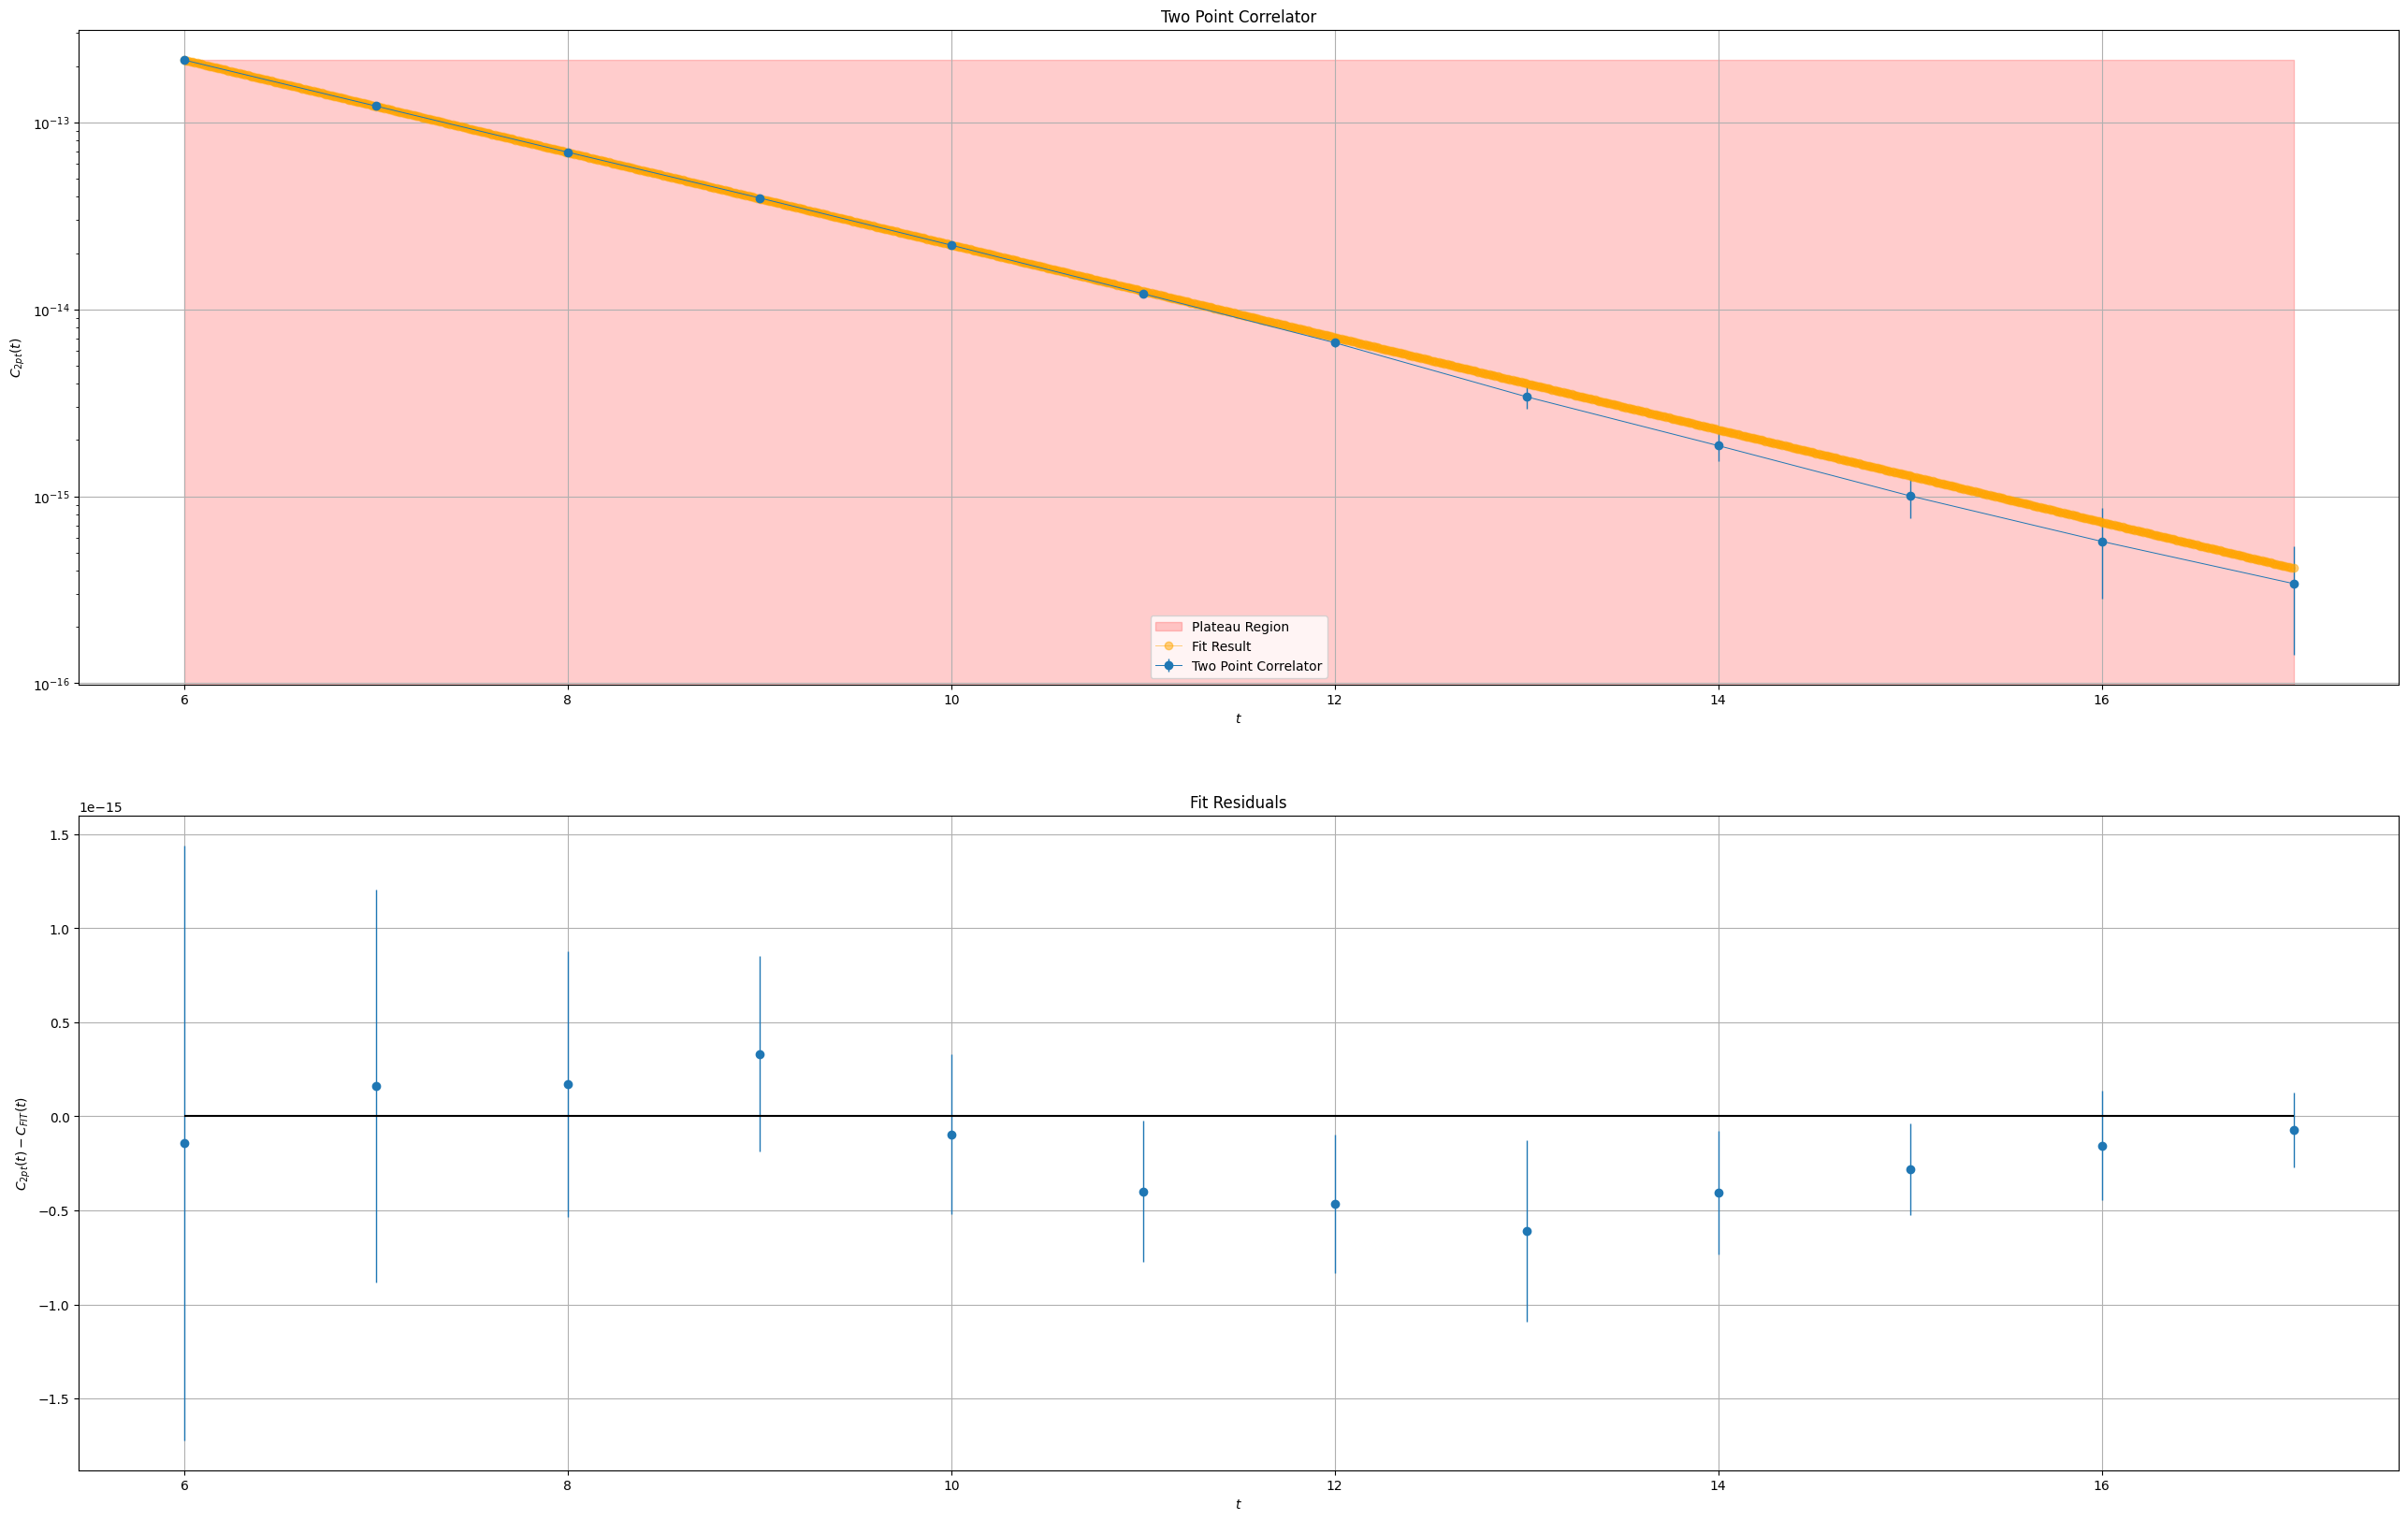

In [10]:
#we instantiate the figure
fig, axlist = plt.subplots(nrows=2,ncols=1,figsize=(32, 20))

ax = axlist[0]



#we determine the time values to be displayed on the plot (x axis)
times = np.arange(np.shape(p2corr_jack)[0]) #+ 0.5

#we decide how much we want to zoom out of the plateau
#zoom = 7

#we plot the plateau and the neighbouring effective mass values
_ = ax.errorbar(times[start_plateau:end_plateau], p2corr_jack[start_plateau:end_plateau], yerr=p2corr_jack_std[start_plateau:end_plateau], linewidth=0.7, marker='o', markersize=6, elinewidth=1.0, label="Two Point Correlator")
#_ = ax.errorbar(times[start_plateau:end_plateau], p2corr[:,start_plateau:end_plateau].mean(axis=0), yerr=p2corr[:,start_plateau:end_plateau].std(axis=0), linewidth=0.7, marker='o', markersize=6, elinewidth=1.0, label="Two Point Correlator")
#ax1.errorbar( np.arange(np.shape(meff)[0]), meff, yerr=meff_std, linewidth=0.7, marker='o', markersize=6, elinewidth=1.0, label="Effective Mass (used for plateau search)")
#ax1.hlines(gv_meff_mean.mean, start_plateau, end_plateau-1, color='red', label="Plateau Region")
#plt.hlines(meff_plat + meff_plat_std, start_plateau+0.5, end_plateau+0.5, color='red', linestyles='dashed')
#plt.hlines(meff_plat - meff_plat_std, start_plateau+0.5, end_plateau+0.5, color='red', linestyles='dashed')
_ = ax.fill_between(times[start_plateau:end_plateau], np.min(p2corr_jack[start_plateau:end_plateau+zoom]), np.max(p2corr_jack[start_plateau:end_plateau]), alpha=0.2, color="red", label="Plateau Region")

fit_x = np.linspace(start_plateau,end_plateau-1,1000)
fit_y = exp_fit_func(t=fit_x, amp=fit_amp, mass=fit_mass)

_ = ax.plot(fit_x,fit_y, linewidth=0.7, marker='o', markersize=6, label="Fit Result", color ="orange",alpha=0.5)

#plot styling
_ = ax.set_title("Two Point Correlator")
_ = ax.set_ylabel(r"$C_{2pt}(t)$")
_ = ax.set_xlabel(r"$t$")
_ = ax.set_yscale("log")
_ = ax.grid()
_ = ax.legend()


ax = axlist[1]


#we determine the time values to be displayed on the plot (x axis)
times = np.arange(np.shape(p2corr_jack)[0]) #+ 0.5

#we decide how much we want to zoom out of the plateau
#zoom = 7

residuals =  p2corr_jack[start_plateau:end_plateau]-exp_fit_func(t=times[start_plateau:end_plateau], amp=fit_amp, mass=fit_mass)

#we plot the plateau and the neighbouring effective mass values
_ = ax.errorbar(times[start_plateau:end_plateau], residuals , yerr=p2corr_jack_std[start_plateau:end_plateau], linewidth=0.0, marker='o', markersize=6, elinewidth=1.0, label="Fit Residuals")


_ = ax.hlines(0,start_plateau, end_plateau-1, color="black")

#plot styling
_ = ax.set_title("Fit Residuals")
_ = ax.set_ylabel(r"$C_{2pt}(t) - C_{FIT}(t)$")
_ = ax.set_xlabel(r"$t$")
_ = ax.grid()


In [11]:
#for the energy we don't know, so we just give a wide prior assuming the energy doubles from ground to first excited state
prior[f"dE1"]= opAnalyzer.m_pi / opAnalyzer.hbarc * opAnalyzer.a_coarse

#the amplitude of the term corresponding to the first excited state we extract by all the other information we have using the functional form of the correlator
t_probe = start_plateau
tmp = (p2corr_jack[t_probe] - prior["A0"] * np.exp(-t_probe*prior["E0"]) ) * np.exp( t_probe * ( prior["dE1"] + prior["E0"]) )
prior[f"A1"] = gv.gvar( 
    gv.mean(tmp),gv.mean(tmp)
                    )

In [12]:
p2corr_jack[t_probe]

np.float64(2.1542075441699433e-13)

In [13]:
prior

BufferDict({'A0': 6.55(41)e-12, 'E0': 0.5690(99), 'dE1': 0.08226(28), 'A1': -4.9(4.9)e-15})

In [14]:
prior["E0"] * opAnalyzer.hbarc / opAnalyzer.a_coarse

prior["dE1"] * opAnalyzer.hbarc / opAnalyzer.a_coarse

965(17)

139.57010(30)

## Complete fit

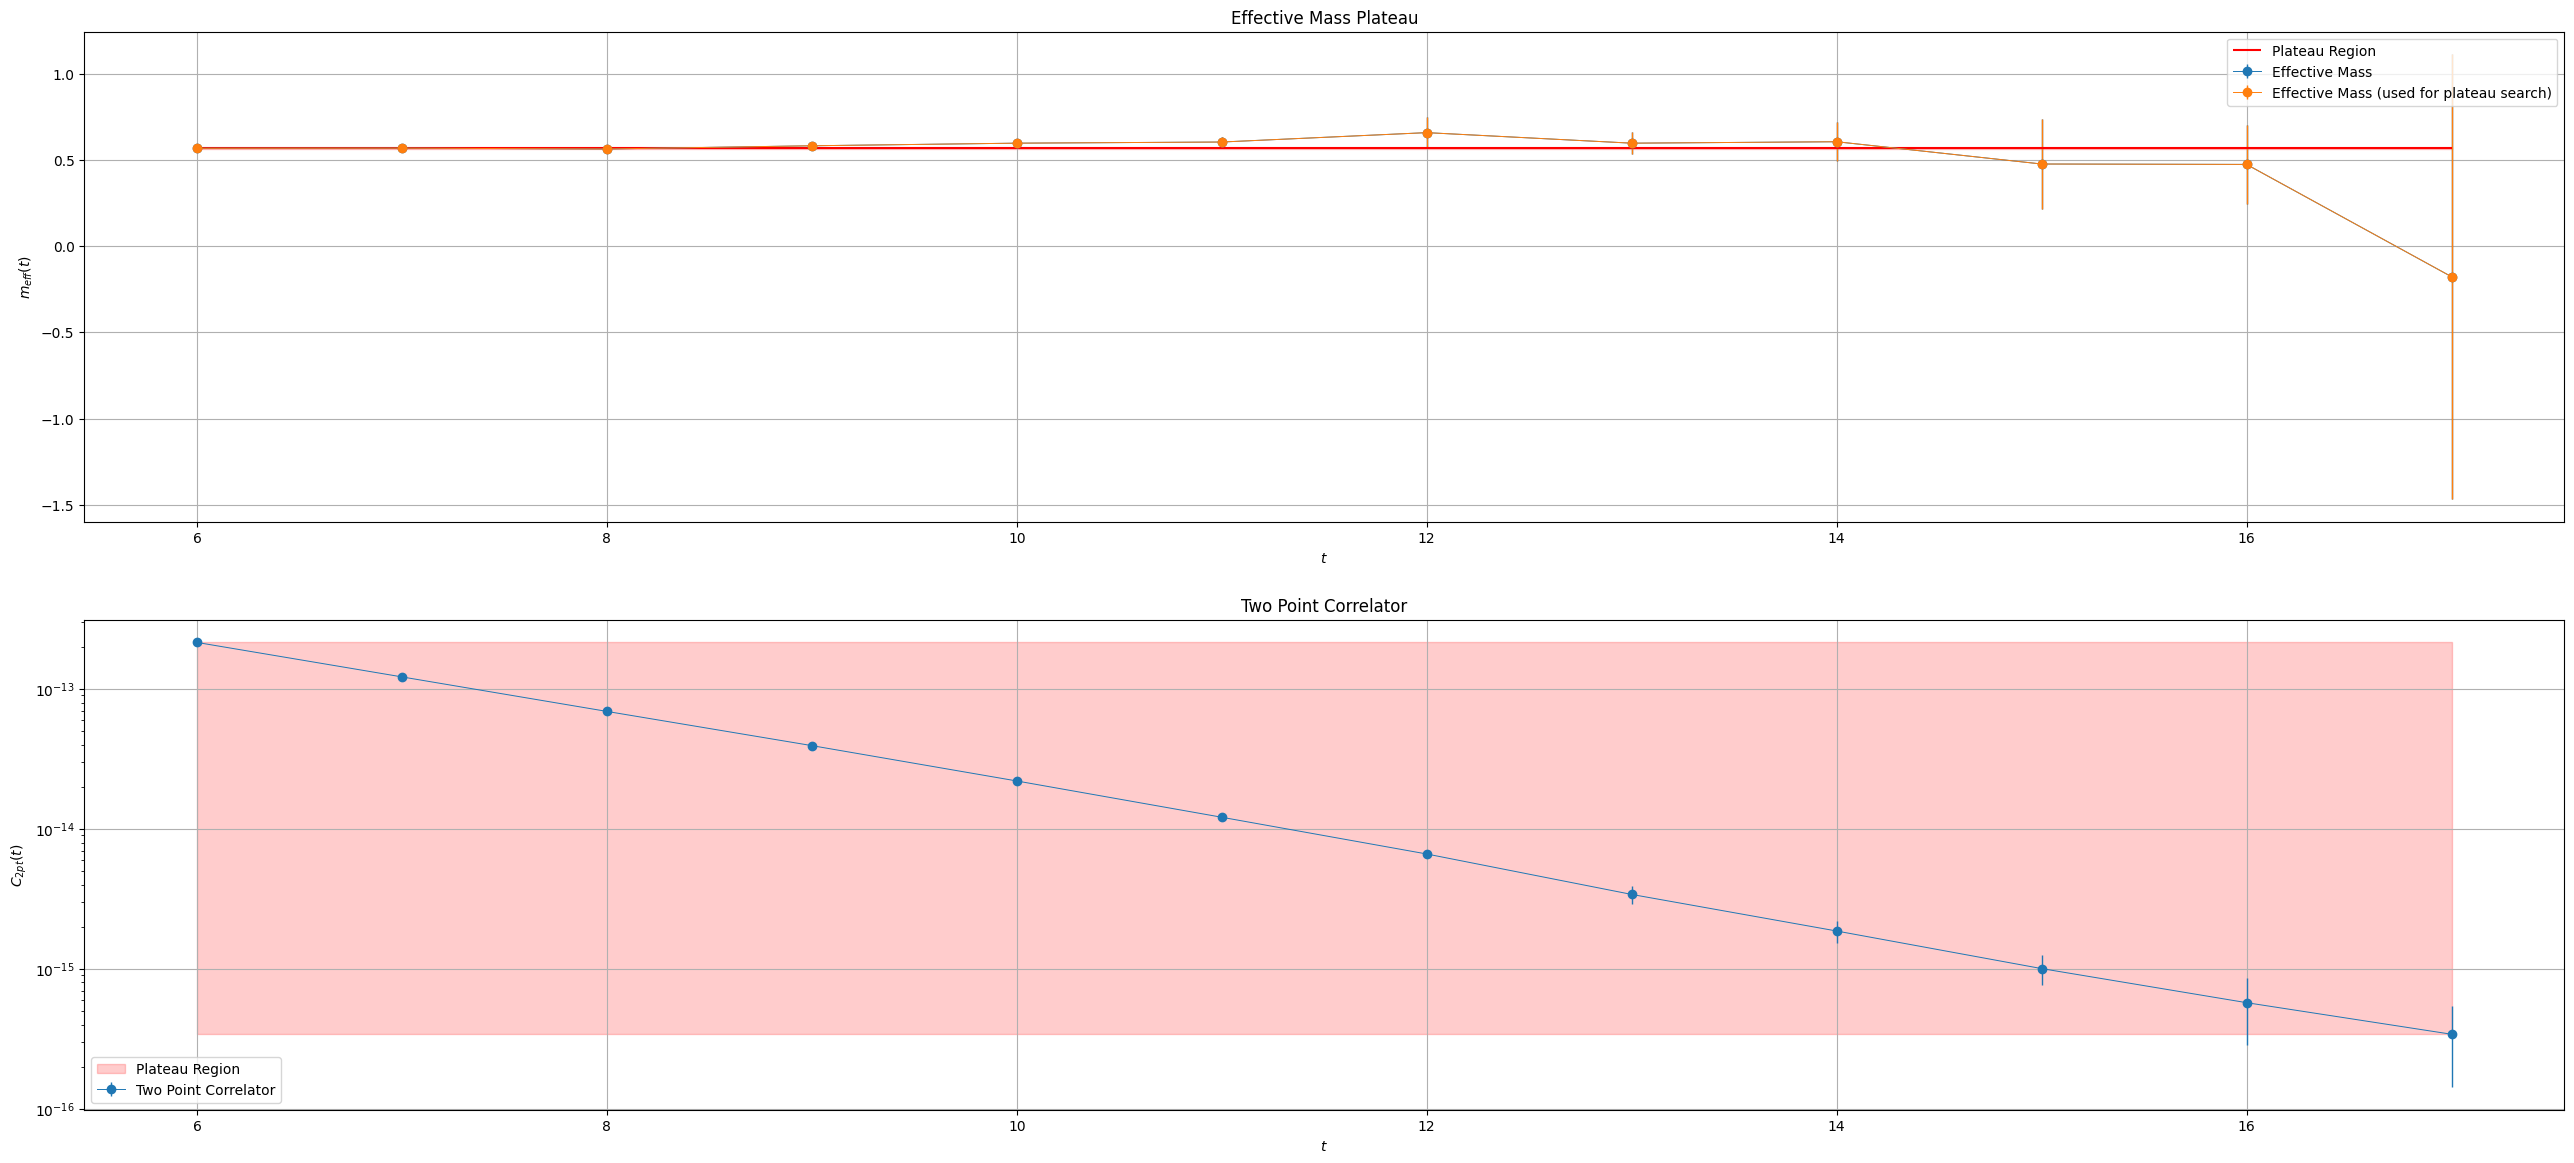

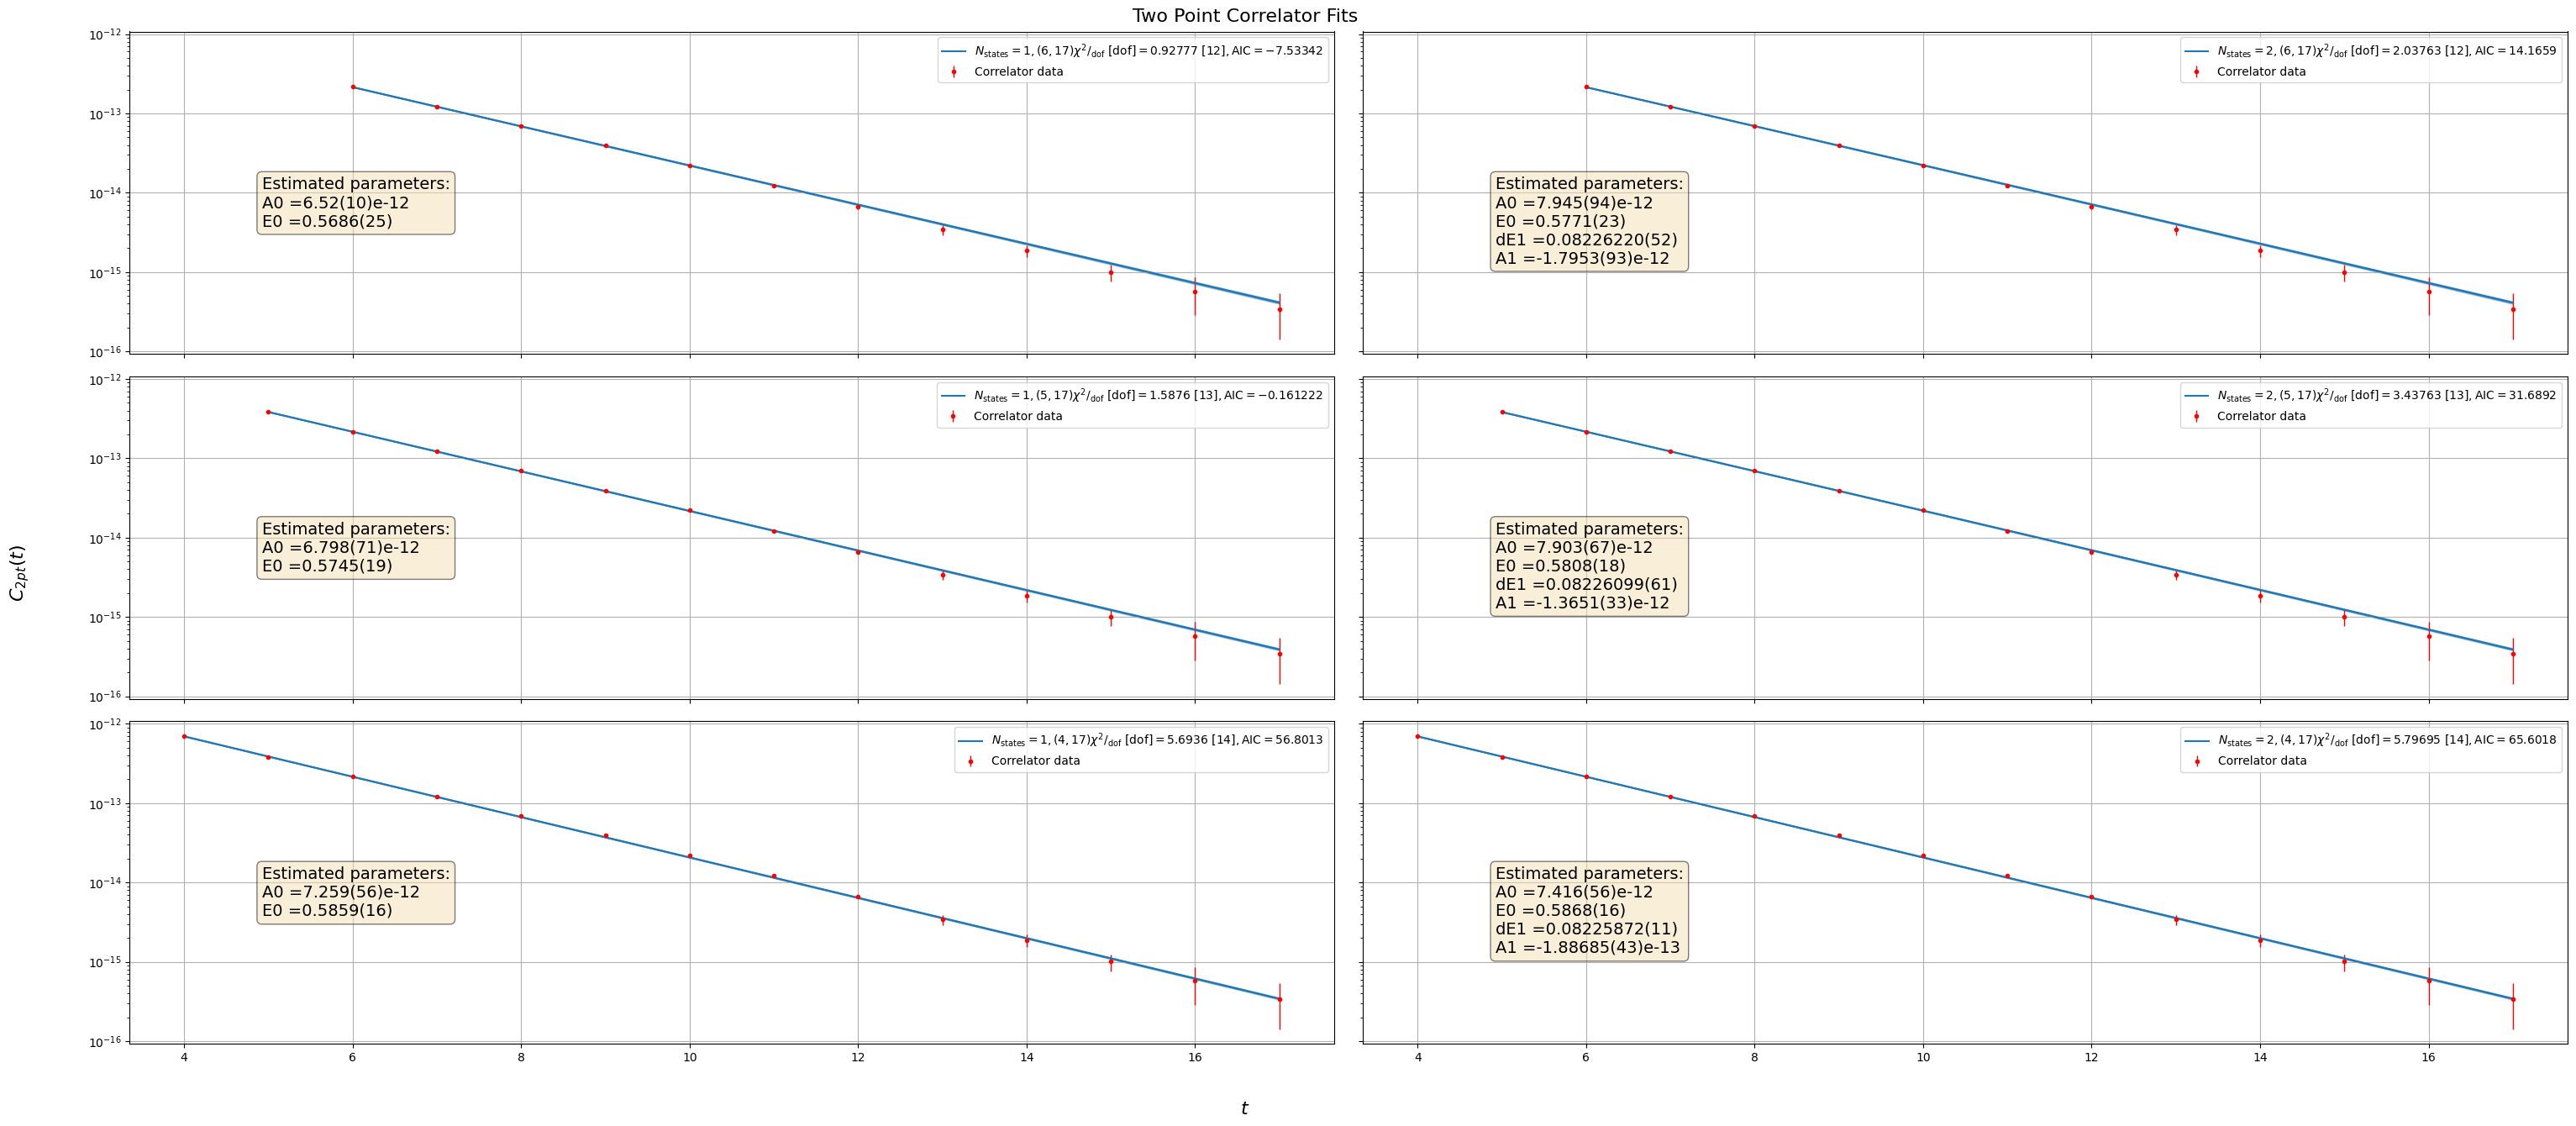

In [15]:
opAnalyzer.set_fit_parms(central_value_fit=True, central_value_fit_correlated=True, resample_fit=True, resample_fit_correlated=True)
fit2p = opAnalyzer.fit_2pcorr(zoom = 0, show=True,save=True,fit_doubt_factor=3)

In [16]:
avg_res = fit2p.model_average()

E0_res = gv.gvar( avg_res["est"]["E0"], avg_res["err"]["E0"] )

dE1_res = gv.gvar( avg_res["est"]["dE1"], avg_res["err"]["dE1"] )

"E0"

E0_res

opAnalyzer.lattice_to_MeV( E0_res ) 

opAnalyzer.lattice_to_MeV( E0_res ) / opAnalyzer.m_p

"dE1"

dE1_res

opAnalyzer.lattice_to_MeV(  dE1_res )

opAnalyzer.lattice_to_MeV(  dE1_res ) / opAnalyzer.m_pi0


'E0'

0.56877(19)

965.0(3.3)

1.0285(36)

'dE1'

0.082262195(35)

139.57(48)

1.0341(36)

In [17]:
opAnalyzer.set_resampling_type('jackknife')
opAnalyzer.get_E()

opAnalyzer.get_E(units="MeV")



opAnalyzer.set_resampling_type('bootstrap')
opAnalyzer.get_E()

opAnalyzer.get_E(units="MeV")

"\n"

opAnalyzer.set_fit_parms(central_value_fit=False, central_value_fit_correlated=False, resample_fit=True, resample_fit_correlated=True)

opAnalyzer.set_resampling_type('jackknife')
opAnalyzer.get_E()

opAnalyzer.get_E(units="MeV")



opAnalyzer.set_resampling_type('bootstrap')
opAnalyzer.get_E()

opAnalyzer.get_E(units="MeV")

0.56877(19)

965.0(3.3)

0.5683(27)

964.2(5.6)

'\n'

0.56877(19)

965.0(3.3)

0.5685(27)

964.6(5.6)

In [18]:
opAnalyzer.set_resampling_type('jackknife')
opAnalyzer.set_fit_parms(central_value_fit=False, central_value_fit_correlated=False, resample_fit=True, resample_fit_correlated=True)
fit2p = opAnalyzer.fit_2pcorr(zoom = 0, show=False,save=False,fit_doubt_factor=3)
avg_res = fit2p.model_average()
E0_res = gv.gvar( avg_res["est"]["E0"], avg_res["err"]["E0"] )
dE1_res = gv.gvar( avg_res["est"]["dE1"], avg_res["err"]["dE1"] )
opAnalyzer.lattice_to_MeV( E0_res ) 
opAnalyzer.lattice_to_MeV( E0_res ) / opAnalyzer.m_p
opAnalyzer.lattice_to_MeV(  dE1_res )
opAnalyzer.lattice_to_MeV(  dE1_res ) / opAnalyzer.m_pi0

965.0(3.3)

1.0285(36)

139.57(48)

1.0341(36)

In [19]:
fit2p.fit_results[0].Nres

212

In [20]:
opAnalyzer.set_resampling_type('bootstrap')
opAnalyzer.set_fit_parms(central_value_fit=False, central_value_fit_correlated=False, resample_fit=True, resample_fit_correlated=True)
fit2p = opAnalyzer.fit_2pcorr(zoom = 0, show=False,save=False,fit_doubt_factor=3)
avg_res = fit2p.model_average()
E0_res = gv.gvar( avg_res["est"]["E0"], avg_res["err"]["E0"] )
dE1_res = gv.gvar( avg_res["est"]["dE1"], avg_res["err"]["dE1"] )
opAnalyzer.lattice_to_MeV( E0_res ) 
opAnalyzer.lattice_to_MeV( E0_res ) / opAnalyzer.m_p
opAnalyzer.lattice_to_MeV(  dE1_res )
opAnalyzer.lattice_to_MeV(  dE1_res ) / opAnalyzer.m_pi0

964.6(5.6)

1.0281(60)

139.58(48)

1.0341(36)

In [21]:
fit2p.fit_results[0].Nres

424

In [22]:
opAnalyzer.set_resampling_type('bootstrap')
opAnalyzer.set_fit_parms(central_value_fit=True, central_value_fit_correlated=True, resample_fit=True, resample_fit_correlated=True)
fit2p = opAnalyzer.fit_2pcorr(zoom = 0, show=False,save=False, fit_doubt_factor=3)
avg_res = fit2p.model_average()
E0_res = gv.gvar( avg_res["est"]["E0"], avg_res["err"]["E0"] )
dE1_res = gv.gvar( avg_res["est"]["dE1"], avg_res["err"]["dE1"] )
opAnalyzer.lattice_to_MeV( E0_res ) 
opAnalyzer.lattice_to_MeV( E0_res ) / opAnalyzer.m_p
opAnalyzer.lattice_to_MeV(  dE1_res )
opAnalyzer.lattice_to_MeV(  dE1_res ) / opAnalyzer.m_pi0

964.2(5.6)

1.0277(60)

139.58(48)

1.0341(36)

In [23]:
"Without resampling"
opAnalyzer.set_fit_parms(central_value_fit=True, central_value_fit_correlated=True, resample_fit=False, resample_fit_correlated=False)
opAnalyzer.get_dE(force_fit=True, units="MeV")
opAnalyzer.get_E(force_fit=False, units="MeV")
opAnalyzer.get_m(force_fit=False, units="MeV")
opAnalyzer.get_dE(force_fit=False, units="lattice")
opAnalyzer.get_E(force_fit=False, units="lattice")
opAnalyzer.get_m(force_fit=False, units="lattice")

"With Resampling"
opAnalyzer.set_fit_parms(central_value_fit=True, central_value_fit_correlated=True, resample_fit=True, resample_fit_correlated=True)
opAnalyzer.get_dE(force_fit=True, units="MeV")
opAnalyzer.get_E(force_fit=False, units="MeV")
opAnalyzer.get_m(force_fit=False, units="MeV")
opAnalyzer.get_dE(force_fit=False, units="lattice")
opAnalyzer.get_E(force_fit=False, units="lattice")
opAnalyzer.get_m(force_fit=False, units="lattice")

'Without resampling'

139.58(68)

964.7(5.5)

964.7(5.5)

0.08227(28)

0.5686(26)

0.5686(26)

'With Resampling'

139.58(48)

964.2(5.6)

964.2(5.6)

0.08226732(86)

0.5683(27)

0.5683(27)

In [24]:
opAnalyzer.MeV_to_lattice(opAnalyzer.m_pi)
gv.gvar( opAnalyzer.MeV_to_lattice(opAnalyzer.m_pi).mean, opAnalyzer.MeV_to_lattice(opAnalyzer.m_pi).sdev*10)

0.08226(28)

0.0823(28)

In [25]:
opAnalyzer

Instance of the moments_toolkit class

Dataset Specifics:
Number of configurations: 212
P: [0 0 0]
q: [0 0 0]

Current Selection of Parameters:
Number of Selected Operators: 0
Selected Isospin: U-D
Selected T values: [3, 4, 5, 6, 7, 8, 10, 12]

Fit parameters:
 - Central Value Fit:            True
 - Central Value Fit Correlated: True
 - Resample Fit:                 True
 - Resample Fit Correlated:      True
 - Resample Fit Resample Prior:  False
 - SVD Cut: None
 - Max Iterations: 10000

Resampling Technique: bootstrap

# Kinematic Factor Proper estimation

In [26]:
#we select some operators
opV1 = 1/6 * opAnalyzer.get_operator(2)
opV2 = 1/(3 * np.sqrt(2)) * (opAnalyzer.get_operator(2) - opAnalyzer.get_operator(3))
opV3 = 1/np.sqrt(2) * opAnalyzer.get_operator(14)

opA1 = 1/np.sqrt(2) * opAnalyzer.get_operator(28)
opA2 = 1/np.sqrt(2) * opAnalyzer.get_operator(32)

opT1 = opAnalyzer.get_operator(74) + 1/2 * opAnalyzer.get_operator(78)
opT2 = opAnalyzer.get_operator(78)
opT3 =  1/6 * ( -3 * opAnalyzer.get_operator(83) + 2 * opAnalyzer.get_operator(87) + 3* opAnalyzer.get_operator(91) + opAnalyzer.get_operator(95) )
opT4 = 1/2 * ( opAnalyzer.get_operator(83) + 2 * opAnalyzer.get_operator(87) -2* opAnalyzer.get_operator(91) )


#we empty the selected op just to be sure
opAnalyzer.deselect_operator()

#we append the operators
opAnalyzer.append_operator(opV1)
opAnalyzer.append_operator(opV2)
opAnalyzer.append_operator(opV3)
opAnalyzer.append_operator(opA1)
opAnalyzer.append_operator(opA2)
opAnalyzer.append_operator(opT1)
opAnalyzer.append_operator(opT2)
opAnalyzer.append_operator(opT3)
opAnalyzer.append_operator(opT4)

In [27]:
#we take mass and energy of g.s.
E0 = opAnalyzer.get_E()
mass = opAnalyzer.get_m()

#we set the momentum to 0
p1 = gv.gvar(opAnalyzer.P_vec[0],0)
p2 = gv.gvar(opAnalyzer.P_vec[1],0)
p3 = gv.gvar(opAnalyzer.P_vec[2],0)

In [28]:
#for each we evaluate the kinematic factor
for iop, op in enumerate(opAnalyzer.selected_op):
    op.K
    op.evaluate_K_gvar(m_value=mass, E_value=E0, p1_value=p1, p2_value=p2, p3_value=p3)

I*(-3*E(p)**3 - 3*E(p)*m_N**2 - 5*E(p)*p_1**2 - 5*E(p)*p_2**2 - 5*E(p)*p_3**2 - 6*m_N**3 - 8*m_N*p_1**2 - 8*m_N*p_2**2 - 8*m_N*p_3**2)/(12*E(p)*(E(p) + m_N))

0.2842(13)

707106781186547*I*(-E(p)**3 - 2*E(p)**2*m_N - E(p)*m_N**2 - E(p)*p_1**2 - E(p)*p_2**2 - 3*E(p)*p_3**2 - 2*m_N*p_3**2)/(2000000000000000*E(p)*(E(p) + m_N))

0.4019(19)

707106781186547*p_1*(E(p)**2 + E(p)*m_N)/(500000000000000*E(p)*(E(p) + m_N))

0 ± 0

707106781186547*I*p_1*(E(p)*m_N + m_N**2 + 2*p_3**2)/(1000000000000000*E(p)*(E(p) + m_N))

0 ± 0

707106781186547*(-E(p)**3 - 2*E(p)**2*m_N - E(p)*m_N**2 + E(p)*p_1**2 + E(p)*p_2**2 - 3*E(p)*p_3**2 - 2*m_N*p_3**2)/(2000000000000000*E(p)*(E(p) + m_N))

-0.4019(19)

p_1*(2*E(p)*m_N + 2*m_N**2 + 2*p_1**2 + 2*p_2**2 + p_3**2)/(E(p)*(E(p) + m_N))

0 ± 0

p_1*(E(p)*m_N + m_N**2 + p_1**2 + p_2**2 + 2*p_3**2)/(E(p)*(E(p) + m_N))

0 ± 0

I*(-E(p)**3 - 2*E(p)**2*m_N - E(p)*m_N**2 - 3*E(p)*p_1**2 - E(p)*p_2**2 + E(p)*p_3**2 - 2*m_N*p_1**2)/(2*E(p)*(E(p) + m_N))

0.5683(27)

I*(-E(p)**3 - E(p)*m_N**2 - 2*E(p)*p_1**2 - 2*E(p)*p_2**2 + E(p)*p_3**2 - 2*m_N**3 - 3*m_N*p_1**2 - 3*m_N*p_2**2 - 2*m_N*p_3**2)/(E(p)*(E(p) + m_N))

1.1366(53)